In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import sys
if not '..' in sys.path:
    sys.path.append('..')
from src.PPP import *
from src.utils import *

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

#### Globals

In [2]:
PATH_RAW = '../data/raw_data/'
PATH_INTER = '../data/intermediate/'
PATH_DATA = '../data/data/'
PATH_MODELS = '../../models/'
PATH_IMAGES = '../assets/images/'

METHOD = 'multiclass'
TO_BIN = False

## Load trianing data

In [3]:
train = pd.read_csv(PATH_INTER + "3200_train.csv")
test = pd.read_csv(PATH_INTER + "800_test.csv")


train, val = preprocess_train(train, text_column='text_review', tag_column='tag', pattern='abcd', split_val=True, val_size=0.1, out_dir=PATH_DATA)
test = preprocess_test(test, text_column='text_review', tag_column='tag', pattern='abcd')
test.to_csv(PATH_DATA + '800_test.csv', index=False)



Preprocessing of the training data...
Files saved to ../data/data/.
Preprocessing finished in 384.83789896965027 seconds.
Preprocessing of the test data...
Preprocessing finished in 95.76912212371826 seconds.


In [12]:
# CRC
train = pd.read_csv(PATH_DATA + "CRC_2880_train.csv", index_col=0)
val = pd.read_csv(PATH_DATA + "CRC_320_val.csv", index_col=0)

# X, y (multiclass) and y (binary) for TRAINING
X_train, y_train, y_bin_train = train.drop(['tag', 'bin_tag'], axis=1), train['tag'].copy(), train['bin_tag'].copy()
# X, y (multiclass) and y (binary) for VALIDATING
X_val, y_val, y_bin_val = val.drop(['tag', 'bin_tag'], axis=1), val['tag'].copy(), val['bin_tag'].copy()

## Load test data

In [44]:
# CRC
test_CRC = pd.read_csv(PATH_DATA + "CRC_800_test.csv", index_col=0)

# X, y (multiclass) and y (binary)
X_test_CRC, y_test_CRC, y_bin_test_CRC = test_CRC.drop(['tag', 'bin_tag'], axis=1), test_CRC['tag'].copy(), test_CRC['bin_tag'].copy()


In [47]:
# SOCC
test_socc = pd.read_csv(PATH_RAW + "socc.csv")

test_socc = preprocess_test(test_socc, text_column='comment_text', tag_column='is_constructive', pattern='yesno')
test_socc = test_socc.rename(columns={'comment_text': 'text_review', 'is_constructive': 'bin_tag'})

# X, y
X_test_socc, y_bin_test_socc = test_socc.drop(['bin_tag'], axis=1), test_socc['bin_tag'].copy()

Preprocessing of the test data...
Preprocessing finished in 11.28348708152771 seconds.


In [45]:
# C3 (extended version of SOCC)
test_c3 = pd.read_csv(PATH_RAW + "C3.csv")

test_c3 = preprocess_test(test_c3, text_column='comment_text', tag_column='constructive_binary', pattern=None)
test_c3 = test_c3.rename(columns={'comment_text': 'text_review', 'constructive_binary': 'bin_tag'})

# X, y
X_test_c3, y_bin_test_c3 = test_c3.drop(['bin_tag'], axis=1), test_c3['bin_tag'].copy()

Preprocessing of the test data...
Preprocessing finished in 135.62197709083557 seconds.


In [47]:
# Lists of data sets for testing
list_X_test = [X_test_CRC]
list_y_test = [y_test_CRC]

#list_X_bin_test = [X_test_CRC, X_test_socc, X_test_c3]
#list_y_bin_test = [y_bin_test_CRC, y_bin_test_socc, y_bin_test_c3]

## Model training

We list the features to use in the Pipeline

In [21]:
numeric_features = list(X_train[['read_score', 'sentiment', 'num_tokens',
                                 'num_char', 'num_upper', 'named_entities',
                                 'num_positives', 'num_negatives', 'num_unk',
                                 'num_punct', 'num_discourse', 'num_modals',
                                 'avg_word_length']])

text_features = list(X_train[['text_review', 'text_pos', 'lemmas']])

Custom transformer to transform the data and create a feature space

In [22]:
trans = ColumnTransformer(transformers=[
            ('review', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,2)), 'text_review'),
            ('pos', TfidfVectorizer(encoding='utf-8', ngram_range=(1,2)), 'text_pos'),
            ('lemma', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,2)), 'lemmas'),
            ('num_attr', StandardScaler(), numeric_features),
            ])

Pipeline to sequentially transform the data and fit an estimator

In [23]:
pipeline = Pipeline([
                       ('union', trans),
                       ('clf', LogisticRegression(max_iter=500, random_state=42))
])

GridSearch with 5 fold cross-validation to find the best set of features

In [59]:
param_grid = [
              #{
               #  'union__review__ngram_range': [(1,1), (1,2)],
                # 'union__pos__ngram_range': [(1,1), (1,2)],
                 #'union__lemma__ngram_range': [(1,1), (1,2)],
                 #'clf': [RandomForestClassifier(),],
                 #'clf__n_estimators': [150, 175],
               #},
              #{
               #  'union__review__ngram_range': [(1,1), (1,2)],
                # 'union__pos__ngram_range': [(1,1), (1,2)],
                 #'union__lemma__ngram_range': [(1,1), (1,2)],
                 #'clf': [LogisticRegression(),],
                 #'clf__max_iter': [500, 1000],
               #},
              {
                  'clf': [GradientBoostingClassifier(n_estimators=100,
                                                     learning_rate=0.5,
                                                     max_depth=16,
                                                     random_state=42)],
                  'clf__class_weight': ['balanced'],
              }
]

# Training with all possible configurations
model = GridSearchCV(pipeline,
                      param_grid=param_grid,
                      scoring='f1_macro',
                      n_jobs=-1,
                      cv=5,
                      verbose=1)

Model fitting...

In [60]:
if METHOD.lower() == 'binary':
    model.fit(X_train, y_bin_train)
elif METHOD.lower() == 'multiclass':
    model.fit(X_train, y_train)
else:
    raise ValueError('You must choose \'binary\' or \'multiclas\'.')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.5min finished


## Model validation

Output of best parameter set and best accuracy average score

In [61]:
print(model.best_score_)
print(model.best_params_)

0.6467631273637215
{'clf': GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=16,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)}


In [62]:
def to_binary(prediction):
    return 0 if prediction == 0 or prediction == 1 else 1

In [65]:
if METHOD.lower() == 'binary':
    y_pred_val = model.predict(X_val)
    print("Accuracy:", accuracy_score(y_bin_val, y_pred_val))
    print("F1 Score:", f1_score(y_bin_val, y_pred_val, average='weighted'))
    print(classification_report(y_bin_val, y_pred_val))
elif METHOD.lower() == 'multiclass':
    y_pred_val = model.predict(X_val)
    if TO_BIN:
        y_pred_val = [to_binary(x) for x in y_pred_val]
        print("Accuracy:", accuracy_score(y_bin_val, y_pred_val))
        print("F1 Score:", f1_score(y_bin_val, y_pred_val, average='weighted'))
        print(classification_report(y_bin_val, y_pred_val))
    else:
        print("Accuracy:", accuracy_score(y_val, y_pred_val))
        print("F1 Score:", f1_score(y_val, y_pred_val, average='weighted'))
        print(classification_report(y_val, y_pred_val))
else:
    raise ValueError('You must choose \'binary\' or \'multiclas\'.')

Accuracy: 0.665625
F1 Score: 0.6649011698500912
              precision    recall  f1-score   support

           0       0.81      0.51      0.63        43
           1       0.69      0.72      0.70       112
           2       0.66      0.68      0.67       120
           3       0.56      0.62      0.59        45

    accuracy                           0.67       320
   macro avg       0.68      0.64      0.65       320
weighted avg       0.67      0.67      0.66       320



Saving model

In [66]:
pickle.dump(model, open(PATH_MODELS+'v0_4_GBC_fullfeatures_withoutval_multiclass.sav', 'wb'))

## Model testing (multiclass model)

Model 1
Accuracy: 0.6625
F1 Score: 0.6585964197572076
              precision    recall  f1-score   support

           0       0.62      0.43      0.51       108
           1       0.69      0.70      0.70       280
           2       0.65      0.72      0.68       300
           3       0.65      0.63      0.64       112

    accuracy                           0.66       800
   macro avg       0.65      0.62      0.63       800
weighted avg       0.66      0.66      0.66       800



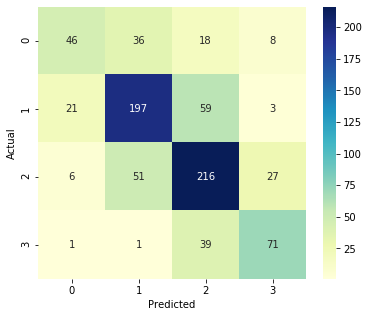

In [69]:
for i, (X, y) in enumerate(zip(list_X_test, list_y_test)):
    y_pred = model.predict(X) 
    print('Model {}'.format(i+1))
    print("Accuracy:", accuracy_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred, average='weighted'))
    print(classification_report(y, y_pred))
    
    conf_mat = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print("="*53)

## Model testing (binary model)

Model 1
Accuracy: 0.9433333333333334
F1 Score: 0.9433938452769391
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94      1097
         1.0       0.96      0.93      0.95      1303

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



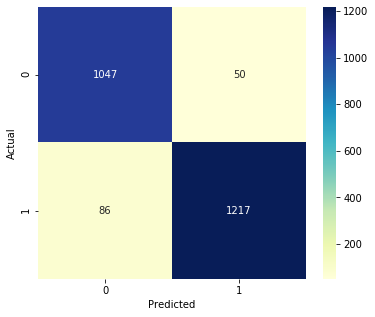

In [26]:
for i, (X, y) in enumerate(zip(list_X_bin_test, list_y_bin_test)):
    y_pred = model.predict(X)
    if len(np.unique(y_pred)) == 4:
        y_pred = [to_binary(x) for x in y_pred]
    print('Model {}'.format(i+1))
    print("Accuracy:", accuracy_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred, average='weighted'))
    print(classification_report(y, y_pred))
    
    conf_mat = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print("="*53)